# CCTV 영상 움직임 감지 및 메타데이터 추출 (SegFormer-Cityscapes)

CCTV 영상에서 움직임이 있는 '중요한' 영역만 식별하여 전체 영상 대신 해당 영역 정보(메타데이터)만 전송함으로써 대역폭과 저장 공간을 절약하는 방법을 구현합니다.

## 프로젝트 목표
- 움직임이 있는 중요 영역만 식별
- 전체 영상 대신 메타데이터만 전송하여 대역폭 절약
- Cityscapes 데이터셋으로 사전 학습된 SegFormer 모델을 사용하여 움직임 영역 세그멘테이션

## 프로젝트 개요 

### 프로젝트 목적
CCTV 영상은 대부분의 시간 동안 변화가 없는 정적인 장면을 담고 있습니다. 전체 영상을 모두 전송하고 저장하는 것은 대역폭과 저장 공간 측면에서 비효율적입니다. 이 프로젝트는 움직임이 있는 중요 영역만 식별하여 해당 영역의 위치 정보(메타데이터)만 전송함으로써 자원을 절약하는 방법을 구현합니다.

### 바운딩 박스
이 프로젝트에서는 움직임이 감지된 영역을 바운딩 박스로 표현합니다.

바운딩 박스는 다음 4가지 값으로 정의됩니다:
- x: 박스의 좌상단 x 좌표
- y: 박스의 좌상단 y 좌표
- width: 박스의 너비
- height: 박스의 높이

### 메타데이터 전송 방식
1. 원본 CCTV 영상에서 움직임이 있는 영역을 AI 모델로 감지
2. 감지된 영역을 바운딩 박스로 변환
3. 바운딩 박스 정보(x, y, width, height)와 타임스탬프를 JSON 형식의 메타데이터로 변환
4. 메타데이터만 전송하여 대역폭 절약 (원본 영상 대비 수백~수천 배 압축 효과)
5. 수신 측에서는 메타데이터를 이용해 움직임 영역만 표시하거나 필요시 해당 영역만 요청


## 1. 환경 설정 및 라이브러리 설치

In [1]:
# 필요한 라이브러리 설치
!pip install -q torch torchvision transformers datasets opencv-python matplotlib numpy scikit-learn tqdm
!pip install -q segmentation-models-pytorch timm albumentations
!pip install -q pandas
!pip install -q transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 68.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 63.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 59.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 29.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
# 필요한 라이브러리 임포트
import os
import re
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import random
import json
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, jaccard_score

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import segmentation_models_pytorch as smp
import albumentations as A
from transformers import SegformerForSemanticSegmentation, SegformerConfig

# 시드 설정
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

set_seed()

In [3]:
!unzip -q /content/put.zip -d /content/output

## 2. 데이터 로드 및 전처리

In [4]:
# 데이터 경로 설정 (Colab 환경에 맞게 조정)
# 데이터를 업로드한 경로로 변경하세요
DATA_DIR = '/content/output'
IMAGES_DIR = os.path.join(DATA_DIR, 'frames')
DIFFS_DIR = os.path.join(DATA_DIR, 'diffs')
MASKS_DIR = os.path.join(DATA_DIR, 'masks')

# 필요한 디렉토리 생성
os.makedirs(MASKS_DIR, exist_ok=True)

In [5]:
# 파일명 패턴 확인 및 매칭 함수 (영어와 숫자만 비교)
def get_matched_triplets_by_stem(images_dir=IMAGES_DIR, masks_dir=MASKS_DIR, diffs_dir=DIFFS_DIR):
    def normalize_filename(filename):
        # 영어와 숫자만 남기고 나머지는 제거
        return re.sub(r'[^a-zA-Z0-9]', '', filename)

    def get_stem(filename, suffix):
        if filename.endswith(suffix):
            # 접미사 제거 후 정규화
            return normalize_filename(filename.replace(suffix, ""))
        return None

    image_files = [f for f in os.listdir(images_dir) if f.endswith("_frame.png")]
    mask_files = [f for f in os.listdir(masks_dir) if f.endswith("_mask.png")]
    diff_files = [f for f in os.listdir(diffs_dir) if f.endswith("_diff.png")]

    print(f"Found {len(image_files)} frame images, {len(mask_files)} mask images, {len(diff_files)} diff images")

    image_stems = {get_stem(f, "_frame.png"): f for f in image_files if get_stem(f, "_frame.png") is not None}
    mask_stems = {get_stem(f, "_mask.png"): f for f in mask_files if get_stem(f, "_mask.png") is not None}
    diff_stems = {get_stem(f, "_diff.png"): f for f in diff_files if get_stem(f, "_diff.png") is not None}

    # 공통 stem 찾기
    common_stems = set(image_stems.keys()) & set(mask_stems.keys()) & set(diff_stems.keys())

    image_paths = [os.path.join(images_dir, image_stems[stem]) for stem in common_stems]
    mask_paths = [os.path.join(masks_dir, mask_stems[stem]) for stem in common_stems]
    diff_paths = [os.path.join(diffs_dir, diff_stems[stem]) for stem in common_stems]

    print(f"Matched samples: {len(common_stems)}")

    # 샘플 확인 출력
    if common_stems:
        sample_stem = list(common_stems)[0]
        print(f"Sample match - Stem: {sample_stem}")
        print(f"  Frame: {image_stems[sample_stem]}")
        print(f"  Mask: {mask_stems[sample_stem]}")
        print(f"  Diff: {diff_stems[sample_stem]}")

    return image_paths, mask_paths, diff_paths

In [6]:
# 매칭된 파일 확인
image_paths, mask_paths, diff_paths = get_matched_triplets_by_stem()

# 매칭된 파일 목록 생성
matched_data = []
for i in range(len(image_paths)):
    matched_data.append({
        'frame': image_paths[i],
        'mask': mask_paths[i],
        'diff': diff_paths[i]
    })

# 데이터 분할 (학습/검증/테스트)
if len(matched_data) > 0:
    # 학습/검증 세트와 테스트 세트 분리
    train_val_data, test_data = train_test_split(matched_data, test_size=0.2, random_state=42)
    # 학습 세트와 검증 세트 분리
    train_data, val_data = train_test_split(train_val_data, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

    print(f"학습 데이터: {len(train_data)}개")
    print(f"검증 데이터: {len(val_data)}개")
    print(f"테스트 데이터: {len(test_data)}개")
else:
    print("매칭된 데이터가 없습니다.")

Found 430 frame images, 234 mask images, 342 diff images
Matched samples: 137
Sample match - Stem: jungangseonbongyanggyo20250410165102
  Frame: [jungangseon]_bongyanggyo_2025-04-10_16-51-02_frame.png
  Mask: [jungangseon_bongyanggyo]__2025-04-10_16-51-02_mask.png
  Diff: [jungangseon]_bongyanggyo_2025-04-10_16-51-02_diff.png
학습 데이터: 81개
검증 데이터: 28개
테스트 데이터: 28개


## 3. 데이터셋 및 모델 정의

### 데이터 증강 (Data Augmentation)

데이터 증강은 제한된 학습 데이터로부터 더 많은 학습 샘플을 생성하여 모델의 일반화 성능을 향상시키는 기법입니다. 이 프로젝트에서는 다음과 같은 데이터 증강 기법을 사용합니다:

1. **수평 뒤집기 (HorizontalFlip)**: 이미지를 좌우로 뒤집어 새로운 샘플 생성
2. **수직 뒤집기 (VerticalFlip)**: 이미지를 상하로 뒤집어 새로운 샘플 생성
3. **90도 회전 (RandomRotate90)**: 이미지를 90도 단위로 무작위 회전
4. **밝기 및 대비 조정 (RandomBrightnessContrast)**: 이미지의 밝기와 대비를 무작위로 조정
5. **색상 변환 (ColorJitter)**: 이미지의 색상, 채도, 색조를 무작위로 변경
6. **가우시안 블러 (GaussianBlur)**: 이미지에 가우시안 블러 적용
7. **그리드 왜곡 (GridDistortion)**: 이미지에 그리드 기반 왜곡 적용

이러한 데이터 증강 기법은 모델이 다양한 조건(조명, 각도, 왜곡 등)에서도 움직임 영역을 정확히 감지할 수 있도록 도와줍니다.

In [7]:
class SegmentationDataset(Dataset):
    def __init__(self, data_list, transform=None, target_size=(256, 256)):
        """
        세그멘테이션 데이터셋

        Args:
            data_list: 데이터 목록 (frame, diff, mask 경로 포함)
            transform: 데이터 변환 함수
            target_size: 모델 입력 크기 (기본값: 256x256)
        """
        self.data_list = data_list
        self.transform = transform
        self.target_size = target_size

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        # 데이터 경로
        frame_path = self.data_list[idx]['frame']
        diff_path = self.data_list[idx]['diff']
        mask_path = self.data_list[idx]['mask']

        # 이미지 로드
        frame = cv2.imread(frame_path)
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)  # BGR -> RGB

        diff = cv2.imread(diff_path, cv2.IMREAD_GRAYSCALE)  # Grayscale
        diff = np.expand_dims(diff, axis=2)  # (H, W) -> (H, W, 1)

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Grayscale
        _, mask = cv2.threshold(mask, 127, 1, cv2.THRESH_BINARY)  # 0, 1 값으로 변환

        # 데이터 변환 적용
        if self.transform:
            augmented = self.transform(image=frame, mask=mask, diff=diff)
            frame = augmented['image']
            mask = augmented['mask']
            diff = augmented['diff']

        # 텐서 변환
        frame = frame.transpose(2, 0, 1).astype('float32') / 255.0  # (H, W, 3) -> (3, H, W)
        diff = diff.transpose(2, 0, 1).astype('float32') / 255.0    # (H, W, 1) -> (1, H, W)

        # 크기 불일치 문제 해결: diff 텐서를 frame 텐서와 동일한 크기로 리사이즈
        if diff.shape[1:] != frame.shape[1:]:
            diff = torch.from_numpy(diff)
            diff = F.interpolate(diff.unsqueeze(0), size=frame.shape[1:], mode='bilinear', align_corners=False).squeeze(0).numpy()

        # 입력: frame(RGB)와 diff 연결 -> 4채널 입력
        x_combined = np.concatenate([frame, diff], axis=0)  # (4, H, W)

        # 출력: 세그멘테이션 마스크
        y = mask.astype('int64')  # (H, W)

        return torch.from_numpy(x_combined), torch.from_numpy(y)

In [8]:
class SegFormerCityscapesWrapper(nn.Module):
    def __init__(self, num_classes=2, pretrained=True):
        """
        Cityscapes 데이터셋으로 사전 학습된 SegFormer 모델 래퍼 클래스

        Args:
            num_classes: 클래스 수 (기본값: 2, 배경과 움직임 영역)
            pretrained: 사전 학습된 가중치 사용 여부
        """
        super(SegFormerCityscapesWrapper, self).__init__()

        # Cityscapes 데이터셋으로 사전 학습된 SegFormer 모델 생성 (B1 크기 사용)
        self.model = SegformerForSemanticSegmentation.from_pretrained(
            "nvidia/segformer-b1-finetuned-cityscapes-1024-1024",
            num_labels=num_classes,
            ignore_mismatched_sizes=True
        )

        # 4채널 입력을 위한 패치 임베딩 레이어 수정
        original_patch_embeddings = self.model.segformer.encoder.patch_embeddings[0]
        original_proj = original_patch_embeddings.proj
        original_weights = original_proj.weight.data

        # 새로운 패치 임베딩 레이어 생성
        in_channels = 4  # RGB + Diff
        hidden_size = original_proj.out_channels
        kernel_size = original_proj.kernel_size
        stride = original_proj.stride
        padding = original_proj.padding

        new_proj = nn.Conv2d(
            in_channels=in_channels,
            out_channels=hidden_size,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
            bias=original_proj.bias is not None
        )

        # 기존 가중치 복사 및 새 채널 초기화
        with torch.no_grad():
            # 기존 RGB 채널 가중치 복사
            new_proj.weight.data[:, :3, :, :] = original_weights[:, :3, :, :]

            # 새로운 채널(Diff)의 가중치 초기화 (기존 채널 평균으로)
            new_proj.weight.data[:, 3:4, :, :] = torch.mean(original_weights[:, :3, :, :], dim=1, keepdim=True)

            # 바이어스 복사 (있는 경우)
            if original_proj.bias is not None:
                new_proj.bias.data = original_proj.bias.data.clone()

        # 패치 임베딩 레이어 교체
        self.model.segformer.encoder.patch_embeddings[0].proj = new_proj

        # 업샘플링 레이어 추가 (출력 크기를 입력 크기와 일치시키기 위함)
        self.upsample = nn.Upsample(scale_factor=4, mode='bilinear', align_corners=False)

    def forward(self, x):
        # SegFormer 모델은 (batch_size, channels, height, width) 형태의 입력을 받음
        outputs = self.model(pixel_values=x)
        # logits 형태: (batch_size, num_classes, height/4, width/4) - 크기가 1/4로 줄어듦

        # 출력 크기를 입력 크기와 일치시키기 위해 업샘플링
        upsampled_logits = self.upsample(outputs.logits)  # (batch_size, num_classes, height, width)

        return upsampled_logits

## 4. 모델 학습

학습 데이터 로더: 11 배치
검증 데이터 로더: 4 배치
입력 텐서 크기: torch.Size([8, 4, 256, 256])
타겟 텐서 크기: torch.Size([8, 256, 256])


<ipython-input-9-ca8cd7b6df60>:52: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-9-ca8cd7b6df60>:52: UserWarning: Glyph 48120 (\N{HANGUL SYLLABLE MI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-9-ca8cd7b6df60>:52: UserWarning: Glyph 51648 (\N{HANGUL SYLLABLE JI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48120 (\N{HANGUL SYLLABLE MI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51648 (\N{HANGUL SYLLABLE JI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(byte

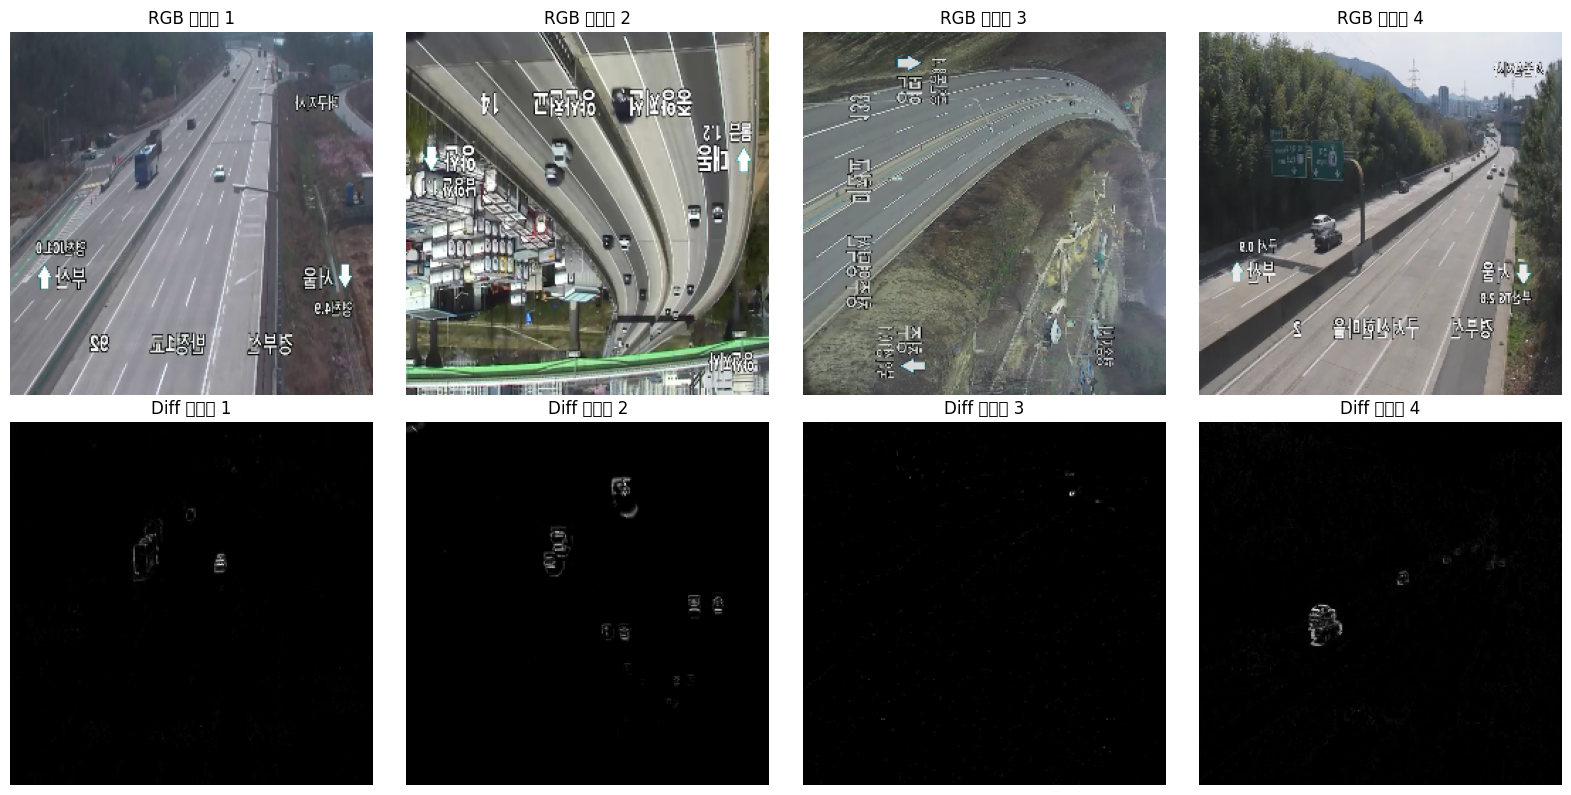

<ipython-input-9-ca8cd7b6df60>:63: UserWarning: Glyph 47560 (\N{HANGUL SYLLABLE MA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-9-ca8cd7b6df60>:63: UserWarning: Glyph 49828 (\N{HANGUL SYLLABLE SEU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-9-ca8cd7b6df60>:63: UserWarning: Glyph 53356 (\N{HANGUL SYLLABLE KEU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47560 (\N{HANGUL SYLLABLE MA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49828 (\N{HANGUL SYLLABLE SEU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 53356 (\N{HANGUL SYLLABLE KEU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figur

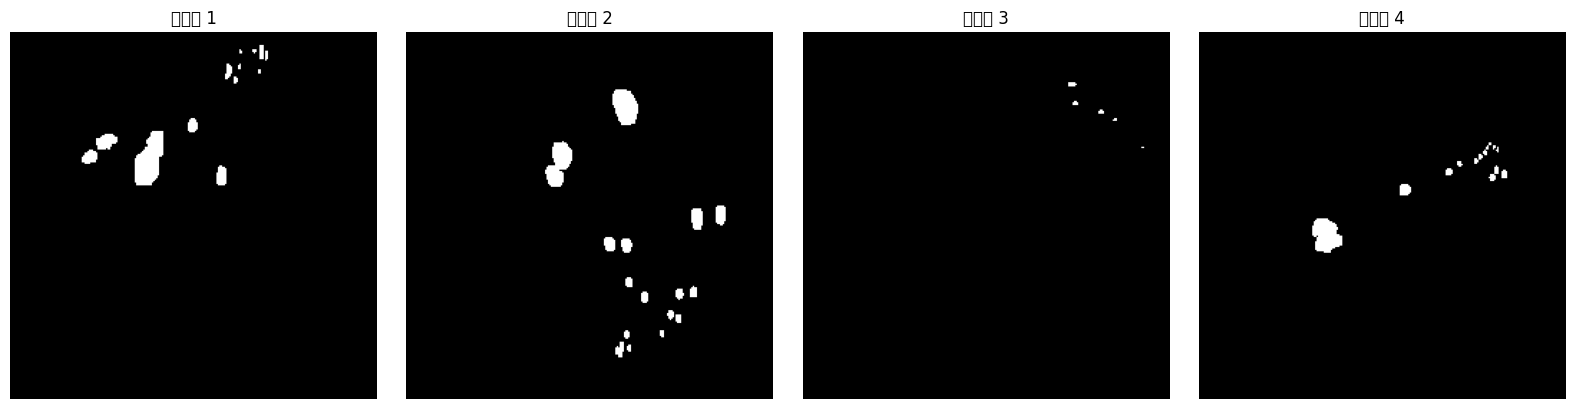

<ipython-input-9-ca8cd7b6df60>:116: UserWarning: Glyph 50896 (\N{HANGUL SYLLABLE WEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-9-ca8cd7b6df60>:116: UserWarning: Glyph 48376 (\N{HANGUL SYLLABLE BON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-9-ca8cd7b6df60>:116: UserWarning: Glyph 54532 (\N{HANGUL SYLLABLE PEU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-9-ca8cd7b6df60>:116: UserWarning: Glyph 47112 (\N{HANGUL SYLLABLE RE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-9-ca8cd7b6df60>:116: UserWarning: Glyph 51076 (\N{HANGUL SYLLABLE IM}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-9-ca8cd7b6df60>:116: UserWarning: Glyph 47560 (\N{HANGUL SYLLABLE MA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-9-ca8cd7b6df60>:116: UserWarning: Glyph 49828 (\N{HANGUL SYLLABLE SEU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython

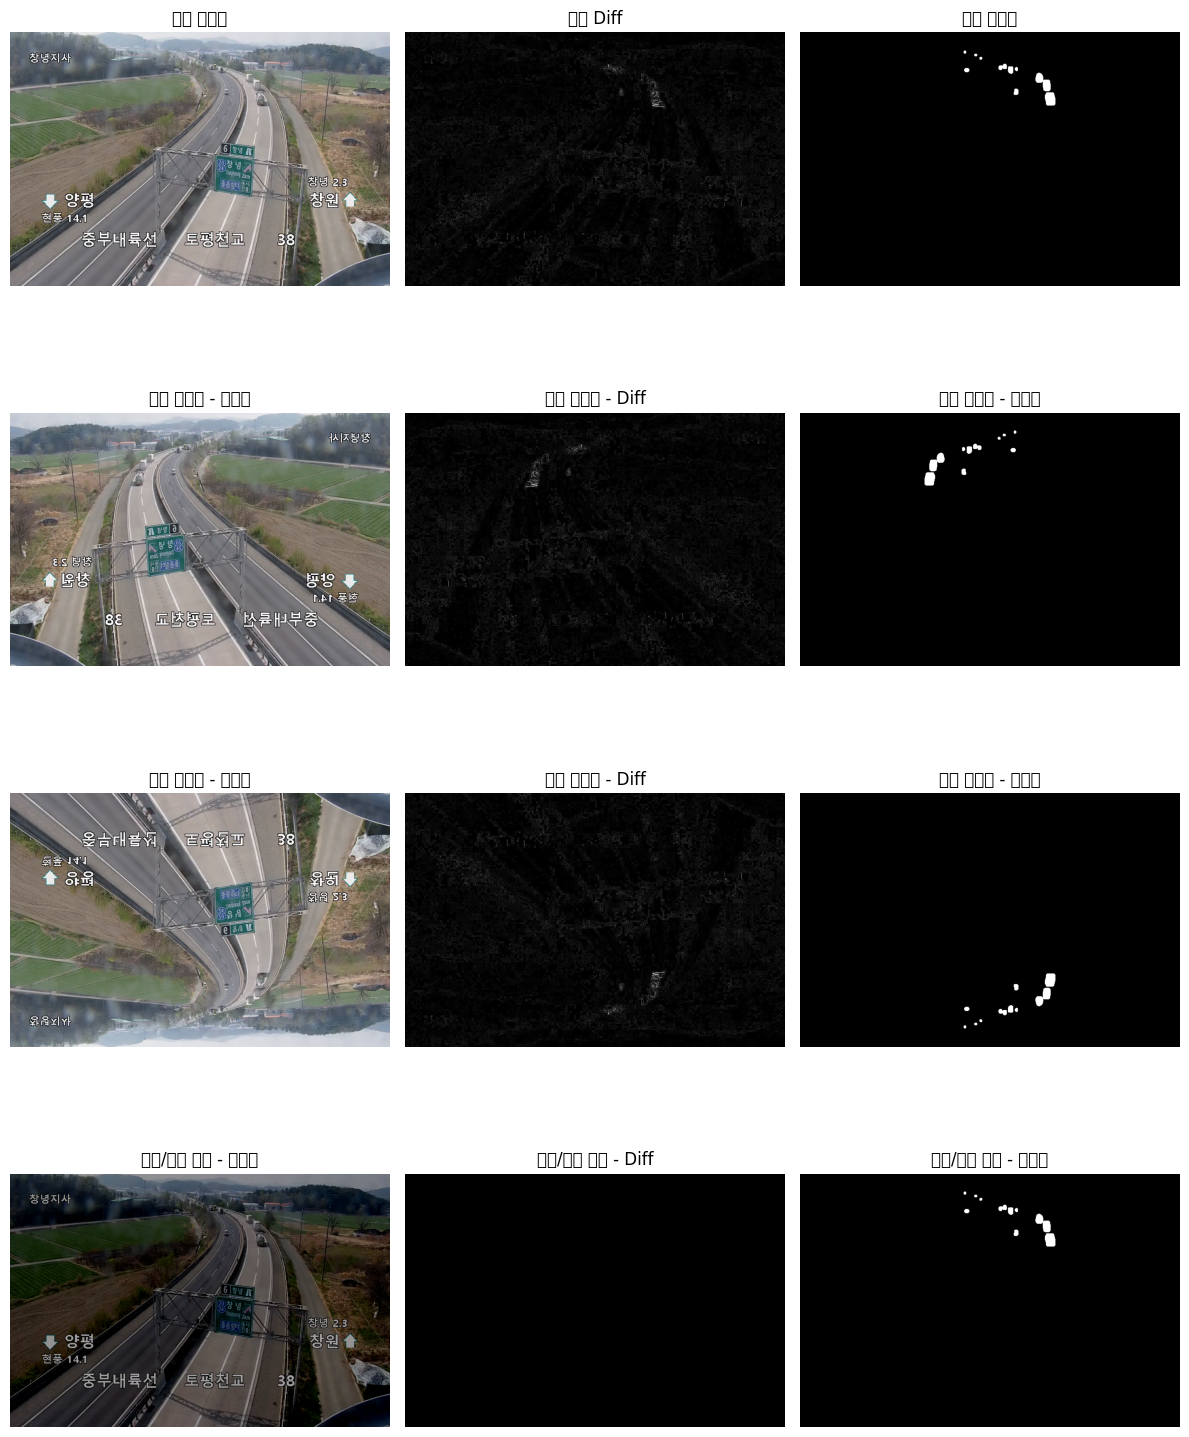

In [9]:
# 데이터셋 및 데이터 로더 생성
if 'train_data' in locals() and 'val_data' in locals() and len(train_data) > 0 and len(val_data) > 0:
    # 데이터 변환 설정 (향상된 데이터 증강 적용)
    train_transform = A.Compose([
        A.Resize(256, 256),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomRotate90(p=0.5),
        A.RandomBrightnessContrast(p=0.3),
        A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=0.3),
        A.GaussianBlur(blur_limit=(3, 7), p=0.2),
        A.GridDistortion(p=0.2),
    ], additional_targets={'diff': 'image'})

    val_transform = A.Compose([
        A.Resize(256, 256),
    ], additional_targets={'diff': 'image'})

    # 데이터셋 생성
    train_dataset = SegmentationDataset(train_data, transform=train_transform)
    val_dataset = SegmentationDataset(val_data, transform=val_transform)

    # 데이터 로더 생성
    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=2)

    print(f"학습 데이터 로더: {len(train_loader)} 배치")
    print(f"검증 데이터 로더: {len(val_loader)} 배치")

    # 샘플 데이터 시각화
    inputs, targets = next(iter(train_loader))
    print(f"입력 텐서 크기: {inputs.shape}")
    print(f"타겟 텐서 크기: {targets.shape}")

    # 샘플 이미지 시각화
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))

    for i in range(4):
        # RGB 이미지
        rgb = inputs[i, :3].permute(1, 2, 0).numpy()
        rgb = np.clip(rgb, 0, 1)
        axes[0, i].imshow(rgb)
        axes[0, i].set_title(f'RGB 이미지 {i+1}')
        axes[0, i].axis('off')

        # Diff 이미지
        diff = inputs[i, 3:].permute(1, 2, 0).numpy()
        axes[1, i].imshow(diff, cmap='gray')
        axes[1, i].set_title(f'Diff 이미지 {i+1}')
        axes[1, i].axis('off')

    plt.tight_layout()
    plt.show()

    # 마스크 시각화
    fig, axes = plt.subplots(1, 4, figsize=(16, 4))

    for i in range(4):
        axes[i].imshow(targets[i].numpy(), cmap='gray')
        axes[i].set_title(f'마스크 {i+1}')
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

    # 데이터 증강 효과 시각화
    sample_data = train_data[0]
    frame = cv2.imread(sample_data['frame'])
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    diff = cv2.imread(sample_data['diff'], cv2.IMREAD_GRAYSCALE)
    diff = np.expand_dims(diff, axis=2)
    mask = cv2.imread(sample_data['mask'], cv2.IMREAD_GRAYSCALE)
    _, mask = cv2.threshold(mask, 127, 1, cv2.THRESH_BINARY)

    # 증강 효과 시각화
    fig, axes = plt.subplots(4, 3, figsize=(12, 16))

    # 원본 이미지
    axes[0, 0].imshow(frame)
    axes[0, 0].set_title('원본 프레임')
    axes[0, 0].axis('off')

    axes[0, 1].imshow(diff, cmap='gray')
    axes[0, 1].set_title('원본 Diff')
    axes[0, 1].axis('off')

    axes[0, 2].imshow(mask, cmap='gray')
    axes[0, 2].set_title('원본 마스크')
    axes[0, 2].axis('off')

    # 다양한 증강 효과 적용
    augmentations = [
        A.HorizontalFlip(p=1),
        A.VerticalFlip(p=1),
        A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=1)
    ]

    titles = ['수평 뒤집기', '수직 뒤집기', '밝기/대비 조정']

    for i, (aug, title) in enumerate(zip(augmentations, titles)):
        transform = A.Compose([aug], additional_targets={'diff': 'image'})
        augmented = transform(image=frame, mask=mask, diff=diff)

        axes[i+1, 0].imshow(augmented['image'])
        axes[i+1, 0].set_title(f'{title} - 프레임')
        axes[i+1, 0].axis('off')

        axes[i+1, 1].imshow(augmented['diff'], cmap='gray')
        axes[i+1, 1].set_title(f'{title} - Diff')
        axes[i+1, 1].axis('off')

        axes[i+1, 2].imshow(augmented['mask'], cmap='gray')
        axes[i+1, 2].set_title(f'{title} - 마스크')
        axes[i+1, 2].axis('off')

    plt.tight_layout()
    plt.show()
else:
    print("학습 및 검증 데이터가 준비되지 않았습니다.")

In [10]:
def train_model(train_loader, val_loader, model, device, num_epochs=10):
    """
    모델 학습

    Args:
        train_loader: 학습 데이터 로더
        val_loader: 검증 데이터 로더
        model: 학습할 모델
        device: 학습 장치 (CPU 또는 GPU)
        num_epochs: 학습 에폭 수
    """
    # 모델을 장치로 이동
    model = model.to(device)

    # 손실 함수 및 옵티마이저 설정
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.01)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=1e-6)

    # 학습 기록
    history = {
        'train_loss': [],
        'val_loss': [],
        'val_iou': []
    }

    # 최적 모델 저장 변수
    best_val_iou = 0
    best_model_path = 'best_segformer_cityscapes_model.pth'

    # 학습 루프
    for epoch in range(num_epochs):
        # 학습 모드
        model.train()
        train_loss = 0

        # 학습 데이터 반복
        for inputs, targets in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} - Training'):
            inputs, targets = inputs.to(device), targets.to(device)

            # 그래디언트 초기화
            optimizer.zero_grad()

            # 순전파
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            # 역전파
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        # 에폭당 평균 학습 손실
        train_loss /= len(train_loader)
        history['train_loss'].append(train_loss)

        # 검증 모드
        model.eval()
        val_loss = 0
        val_iou = 0

        with torch.no_grad():
            for inputs, targets in tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} - Validation'):
                inputs, targets = inputs.to(device), targets.to(device)

                # 순전파
                outputs = model(inputs)
                loss = criterion(outputs, targets)

                val_loss += loss.item()

                # IoU 계산
                preds = torch.argmax(outputs, dim=1)
                intersection = torch.logical_and(preds, targets).sum().item()
                union = torch.logical_or(preds, targets).sum().item()
                batch_iou = intersection / union if union > 0 else 0
                val_iou += batch_iou

        # 에폭당 평균 검증 손실 및 IoU
        val_loss /= len(val_loader)
        val_iou /= len(val_loader)
        history['val_loss'].append(val_loss)
        history['val_iou'].append(val_iou)

        # 학습률 조정
        scheduler.step()

        # 최적 모델 저장
        if val_iou > best_val_iou:
            best_val_iou = val_iou
            torch.save(model.state_dict(), best_model_path)
            print(f"Epoch {epoch+1}: 최적 모델 저장 (IoU: {val_iou:.4f})")

        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val IoU: {val_iou:.4f}")

    # 최적 모델 로드
    model.load_state_dict(torch.load(best_model_path))

    # 학습 곡선 시각화
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss Curves')

    plt.subplot(1, 2, 2)
    plt.plot(history['val_iou'], label='Val IoU')
    plt.xlabel('Epoch')
    plt.ylabel('IoU')
    plt.legend()
    plt.title('IoU Curve')

    plt.tight_layout()
    plt.show()

    return model, history

사용 장치: cuda


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.68k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/54.8M [00:00<?, ?B/s]

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b1-finetuned-cityscapes-1024-1024 and are newly initialized because the shapes did not match:
- decode_head.classifier.weight: found shape torch.Size([19, 256, 1, 1]) in the checkpoint and torch.Size([2, 256, 1, 1]) in the model instantiated
- decode_head.classifier.bias: found shape torch.Size([19]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Cityscapes 데이터셋으로 사전 학습된 SegFormer 모델이 생성되었습니다.


Epoch 1/10 - Training:   0%|          | 0/11 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/54.8M [00:00<?, ?B/s]

Epoch 1/10 - Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1: 최적 모델 저장 (IoU: 0.0334)
Epoch 1/10 - Train Loss: 0.7182, Val Loss: 0.6670, Val IoU: 0.0334


Epoch 2/10 - Training:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 2/10 - Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 2: 최적 모델 저장 (IoU: 0.0601)
Epoch 2/10 - Train Loss: 0.6534, Val Loss: 0.6151, Val IoU: 0.0601


Epoch 3/10 - Training:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 3/10 - Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 3: 최적 모델 저장 (IoU: 0.1429)
Epoch 3/10 - Train Loss: 0.5975, Val Loss: 0.5176, Val IoU: 0.1429


Epoch 4/10 - Training:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 4/10 - Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 4: 최적 모델 저장 (IoU: 0.1927)
Epoch 4/10 - Train Loss: 0.5483, Val Loss: 0.4859, Val IoU: 0.1927


Epoch 5/10 - Training:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 5/10 - Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 5/10 - Train Loss: 0.5120, Val Loss: 0.4581, Val IoU: 0.1881


Epoch 6/10 - Training:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 6/10 - Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 6: 최적 모델 저장 (IoU: 0.2059)
Epoch 6/10 - Train Loss: 0.4816, Val Loss: 0.4406, Val IoU: 0.2059


Epoch 7/10 - Training:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 7/10 - Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 7: 최적 모델 저장 (IoU: 0.2282)
Epoch 7/10 - Train Loss: 0.4605, Val Loss: 0.4100, Val IoU: 0.2282


Epoch 8/10 - Training:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 8/10 - Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 8: 최적 모델 저장 (IoU: 0.2335)
Epoch 8/10 - Train Loss: 0.4489, Val Loss: 0.4074, Val IoU: 0.2335


Epoch 9/10 - Training:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 9/10 - Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 9: 최적 모델 저장 (IoU: 0.2378)
Epoch 9/10 - Train Loss: 0.4412, Val Loss: 0.4058, Val IoU: 0.2378


Epoch 10/10 - Training:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 10/10 - Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 10/10 - Train Loss: 0.4330, Val Loss: 0.4013, Val IoU: 0.2291


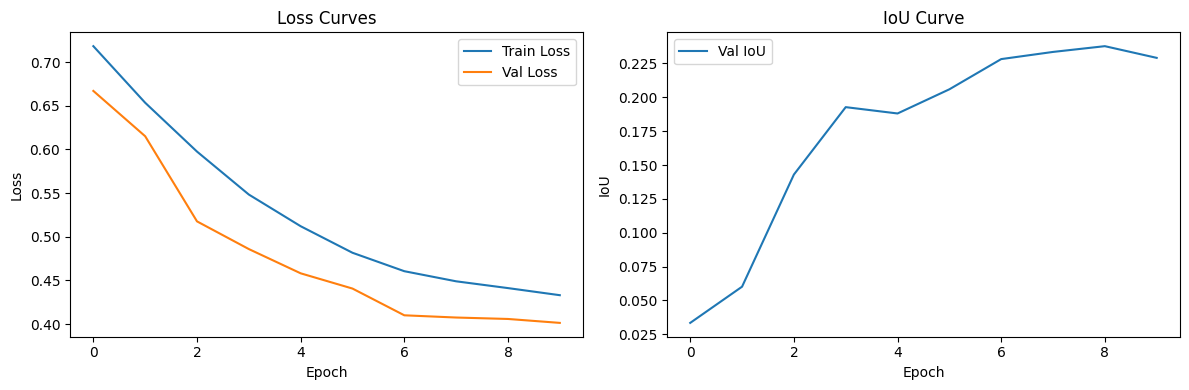

In [11]:
# 모델 생성 및 학습 (데이터 로더가 준비된 경우 실행)
if 'train_loader' in locals() and 'val_loader' in locals():
    # 장치 설정
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"사용 장치: {device}")

    # 모델 생성
    model = SegFormerCityscapesWrapper(num_classes=2)
    print("Cityscapes 데이터셋으로 사전 학습된 SegFormer 모델이 생성되었습니다.")

    # 모델 학습
    trained_model, history = train_model(
        train_loader=train_loader,
        val_loader=val_loader,
        model=model,
        device=device,
        num_epochs=10  # 에폭 수 조정
    )
else:
    print("데이터 로더가 준비되지 않았습니다.")

## 5. 모델 평가 및 메타데이터 생성

In [12]:
def evaluate_model(model, test_data, device, threshold=0.5, min_area=100, visualize=True):
    """
    학습된 모델 평가

    Args:
        model: 평가할 모델
        test_data: 테스트 데이터 목록
        device: 평가 장치 (CPU 또는 GPU)
        threshold: 세그멘테이션 임계값
        min_area: 최소 윤곽선 면적
        visualize: 시각화 여부
    """
    # 테스트 데이터셋 생성
    test_transform = A.Compose([
        A.Resize(256, 256),
    ], additional_targets={'diff': 'image'})

    test_dataset = SegmentationDataset(test_data, transform=test_transform)
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=2)

    # 평가 모드
    model.eval()
    model = model.to(device)

    # 성능 지표
    mask_iou_scores = []
    box_iou_scores = []
    precision_scores = []
    recall_scores = []

    # 메타데이터 저장
    metadata_list = []

    with torch.no_grad():
        for i, (inputs, targets) in enumerate(tqdm(test_loader, desc="모델 평가 중")):
            inputs, targets = inputs.to(device), targets.to(device)

            # 순전파
            outputs = model(inputs)

            # 예측 마스크 생성
            probs = torch.softmax(outputs, dim=1)[:, 1]  # 클래스 1(움직임)의 확률
            pred_masks = (probs > threshold).cpu().numpy().astype(np.uint8)

            # Ground Truth 마스크
            gt_masks = targets.cpu().numpy().astype(np.uint8)

            # 원본 이미지 크기로 복원
            original_frame = cv2.imread(test_data[i]['frame'])
            original_height, original_width = original_frame.shape[:2]

            pred_mask_resized = cv2.resize(pred_masks[0], (original_width, original_height), interpolation=cv2.INTER_NEAREST)
            gt_mask_resized = cv2.resize(gt_masks[0], (original_width, original_height), interpolation=cv2.INTER_NEAREST)

            # 마스크 IoU 계산
            intersection = np.logical_and(pred_mask_resized, gt_mask_resized).sum()
            union = np.logical_or(pred_mask_resized, gt_mask_resized).sum()
            mask_iou = intersection / union if union > 0 else 0
            mask_iou_scores.append(mask_iou)

            # 바운딩 박스 생성 (예측 마스크 기반)
            contours, _ = cv2.findContours(pred_mask_resized, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            pred_boxes = []
            for contour in contours:
                if cv2.contourArea(contour) < min_area:
                    continue
                x, y, w, h = cv2.boundingRect(contour)
                pred_boxes.append((x, y, w, h))

            # 바운딩 박스 마스크 생성
            pred_box_mask = np.zeros_like(pred_mask_resized)
            for box in pred_boxes:
                x, y, w, h = box
                pred_box_mask[y:y+h, x:x+w] = 1

            # Ground Truth 바운딩 박스 생성
            gt_contours, _ = cv2.findContours(gt_mask_resized, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            gt_boxes = []
            for contour in gt_contours:
                x, y, w, h = cv2.boundingRect(contour)
                gt_boxes.append((x, y, w, h))

            # Ground Truth 바운딩 박스 마스크 생성
            gt_box_mask = np.zeros_like(gt_mask_resized)
            for box in gt_boxes:
                x, y, w, h = box
                gt_box_mask[y:y+h, x:x+w] = 1

            # 바운딩 박스 IoU 계산
            box_intersection = np.logical_and(pred_box_mask, gt_box_mask).sum()
            box_union = np.logical_or(pred_box_mask, gt_box_mask).sum()
            box_iou = box_intersection / box_union if box_union > 0 else 0
            box_iou_scores.append(box_iou)

            # Precision, Recall 계산
            tp = box_intersection
            fp = pred_box_mask.sum() - tp
            fn = gt_box_mask.sum() - tp

            precision = tp / (tp + fp) if (tp + fp) > 0 else 0
            recall = tp / (tp + fn) if (tp + fn) > 0 else 0

            precision_scores.append(precision)
            recall_scores.append(recall)

            # 메타데이터 저장
            timestamp = re.search(r'(\d{4}-\d{2}-\d{2}_\d{2}-\d{2}-\d{2})', test_data[i]['frame']).group(1)
            metadata = {
                'timestamp': timestamp,
                'bounding_boxes': [{'x': x, 'y': y, 'width': w, 'height': h} for x, y, w, h in pred_boxes]
            }
            metadata_list.append(metadata)

            # 시각화 (처음 5개 샘플만)
            if visualize and i < 5:
                # 원본 프레임
                frame = cv2.cvtColor(original_frame, cv2.COLOR_BGR2RGB)

                # 결과 시각화
                fig, axes = plt.subplots(2, 3, figsize=(15, 10))

                # 원본 프레임
                axes[0, 0].imshow(frame)
                axes[0, 0].set_title('원본 프레임')
                axes[0, 0].axis('off')

                # 예측 마스크
                axes[0, 1].imshow(pred_mask_resized, cmap='gray')
                axes[0, 1].set_title('예측 마스크')
                axes[0, 1].axis('off')

                # Ground Truth 마스크
                axes[0, 2].imshow(gt_mask_resized, cmap='gray')
                axes[0, 2].set_title('Ground Truth 마스크')
                axes[0, 2].axis('off')

                # 예측 바운딩 박스 마스크
                axes[1, 0].imshow(pred_box_mask, cmap='gray')
                axes[1, 0].set_title('예측 바운딩 박스 마스크')
                axes[1, 0].axis('off')

                # Ground Truth 바운딩 박스 마스크
                axes[1, 1].imshow(gt_box_mask, cmap='gray')
                axes[1, 1].set_title('GT 바운딩 박스 마스크')
                axes[1, 1].axis('off')

                # 바운딩 박스 시각화
                frame_with_boxes = frame.copy()
                # 예측 바운딩 박스 (빨간색)
                for box in pred_boxes:
                    x, y, w, h = box
                    cv2.rectangle(frame_with_boxes, (x, y), (x+w, y+h), (255, 0, 0), 2)

                # Ground Truth 바운딩 박스 (초록색)
                for box in gt_boxes:
                    x, y, w, h = box
                    cv2.rectangle(frame_with_boxes, (x, y), (x+w, y+h), (0, 255, 0), 2)

                axes[1, 2].imshow(frame_with_boxes)
                axes[1, 2].set_title('바운딩 박스 (빨강: 예측, 초록: GT)')
                axes[1, 2].axis('off')

                plt.tight_layout()
                plt.show()

                print(f"샘플 {i+1} - 마스크 IoU: {mask_iou:.4f}, 박스 IoU: {box_iou:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")

    # 평균 성능 지표
    mean_mask_iou = np.mean(mask_iou_scores)
    mean_box_iou = np.mean(box_iou_scores)
    mean_precision = np.mean(precision_scores)
    mean_recall = np.mean(recall_scores)
    f1 = 2 * mean_precision * mean_recall / (mean_precision + mean_recall) if (mean_precision + mean_recall) > 0 else 0

    print("\nSegFormer Cityscapes 모델 성능:")
    print(f"평균 마스크 IoU: {mean_mask_iou:.4f}")
    print(f"평균 박스 IoU: {mean_box_iou:.4f}")
    print(f"평균 Precision: {mean_precision:.4f}")
    print(f"평균 Recall: {mean_recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    # 메타데이터 저장
    with open('segformer_cityscapes_metadata.json', 'w') as f:
        json.dump(metadata_list, f, indent=2)

    print(f"메타데이터가 'segformer_cityscapes_metadata.json' 파일로 저장되었습니다.")

    return {
        'mask_iou': mean_mask_iou,
        'box_iou': mean_box_iou,
        'precision': mean_precision,
        'recall': mean_recall,
        'f1': f1
    }

모델 평가 중:   0%|          | 0/28 [00:00<?, ?it/s]

<ipython-input-12-abe50b87dd02>:163: UserWarning: Glyph 50896 (\N{HANGUL SYLLABLE WEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-12-abe50b87dd02>:163: UserWarning: Glyph 48376 (\N{HANGUL SYLLABLE BON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-12-abe50b87dd02>:163: UserWarning: Glyph 54532 (\N{HANGUL SYLLABLE PEU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-12-abe50b87dd02>:163: UserWarning: Glyph 47112 (\N{HANGUL SYLLABLE RE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-12-abe50b87dd02>:163: UserWarning: Glyph 51076 (\N{HANGUL SYLLABLE IM}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-12-abe50b87dd02>:163: UserWarning: Glyph 50696 (\N{HANGUL SYLLABLE YE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-12-abe50b87dd02>:163: UserWarning: Glyph 52769 (\N{HANGUL SYLLABLE CEUG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


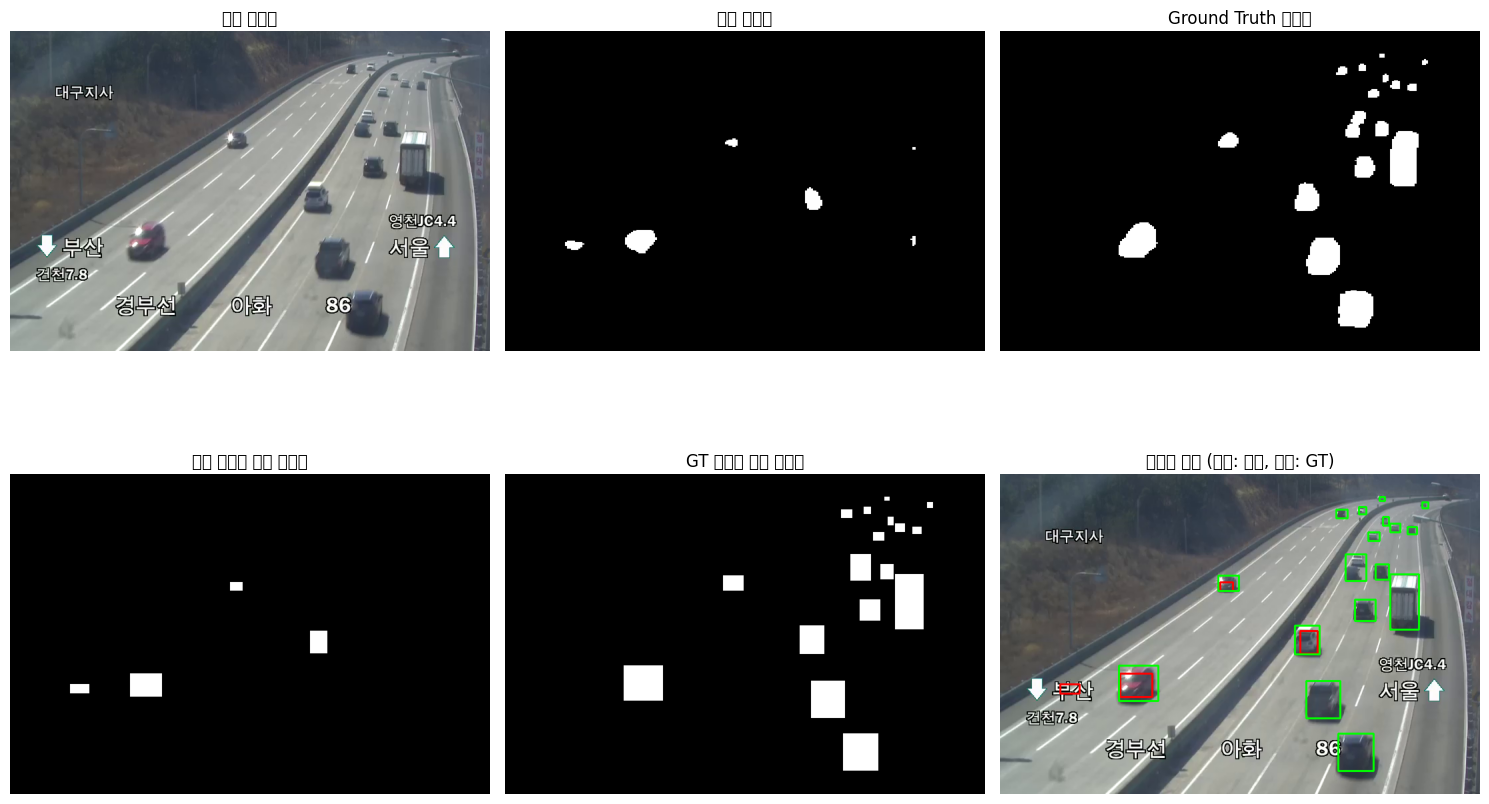

샘플 1 - 마스크 IoU: 0.1280, 박스 IoU: 0.1473, Precision: 0.8738, Recall: 0.1505


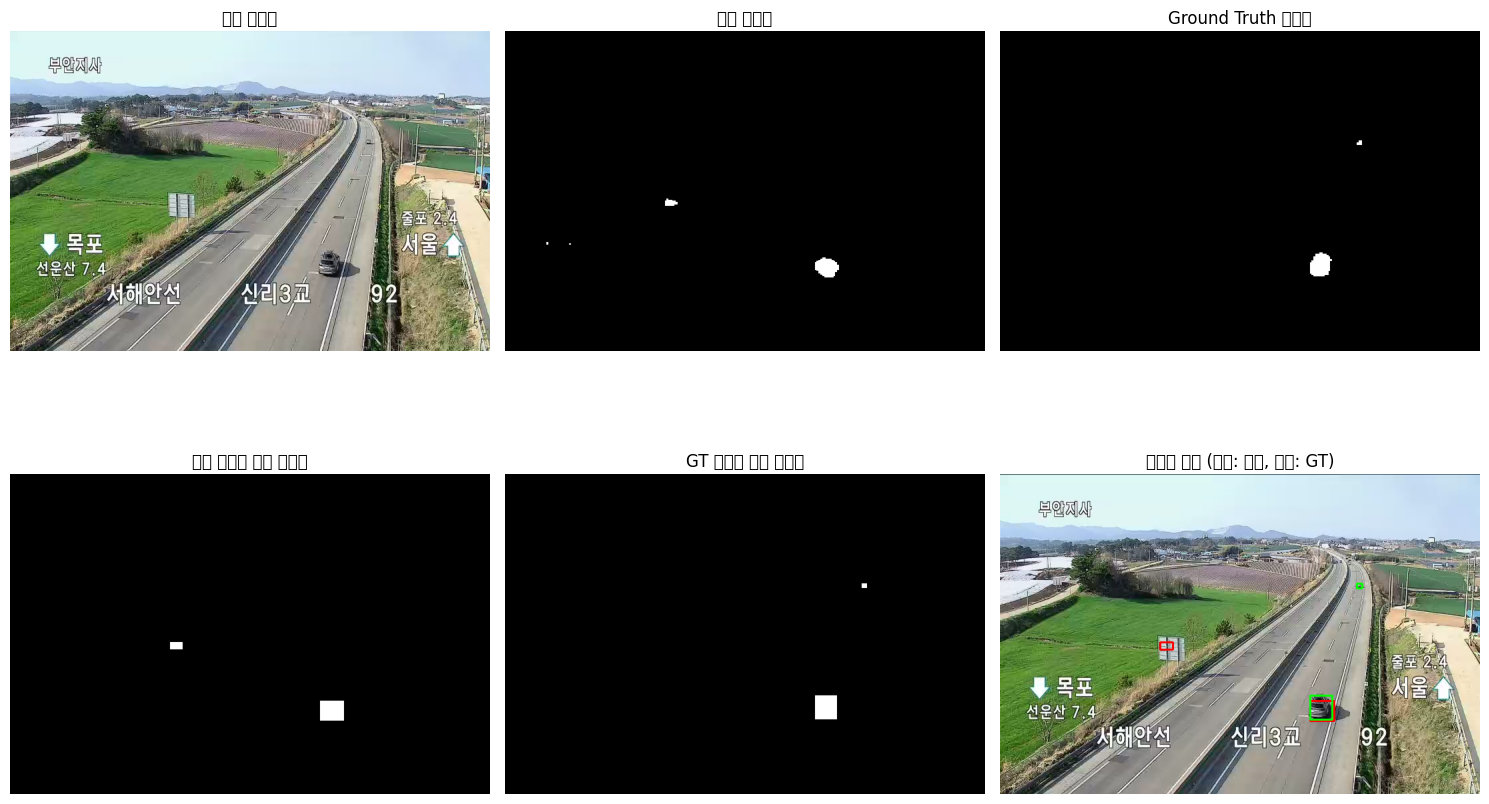

샘플 2 - 마스크 IoU: 0.5295, 박스 IoU: 0.5743, Precision: 0.7168, Recall: 0.7428


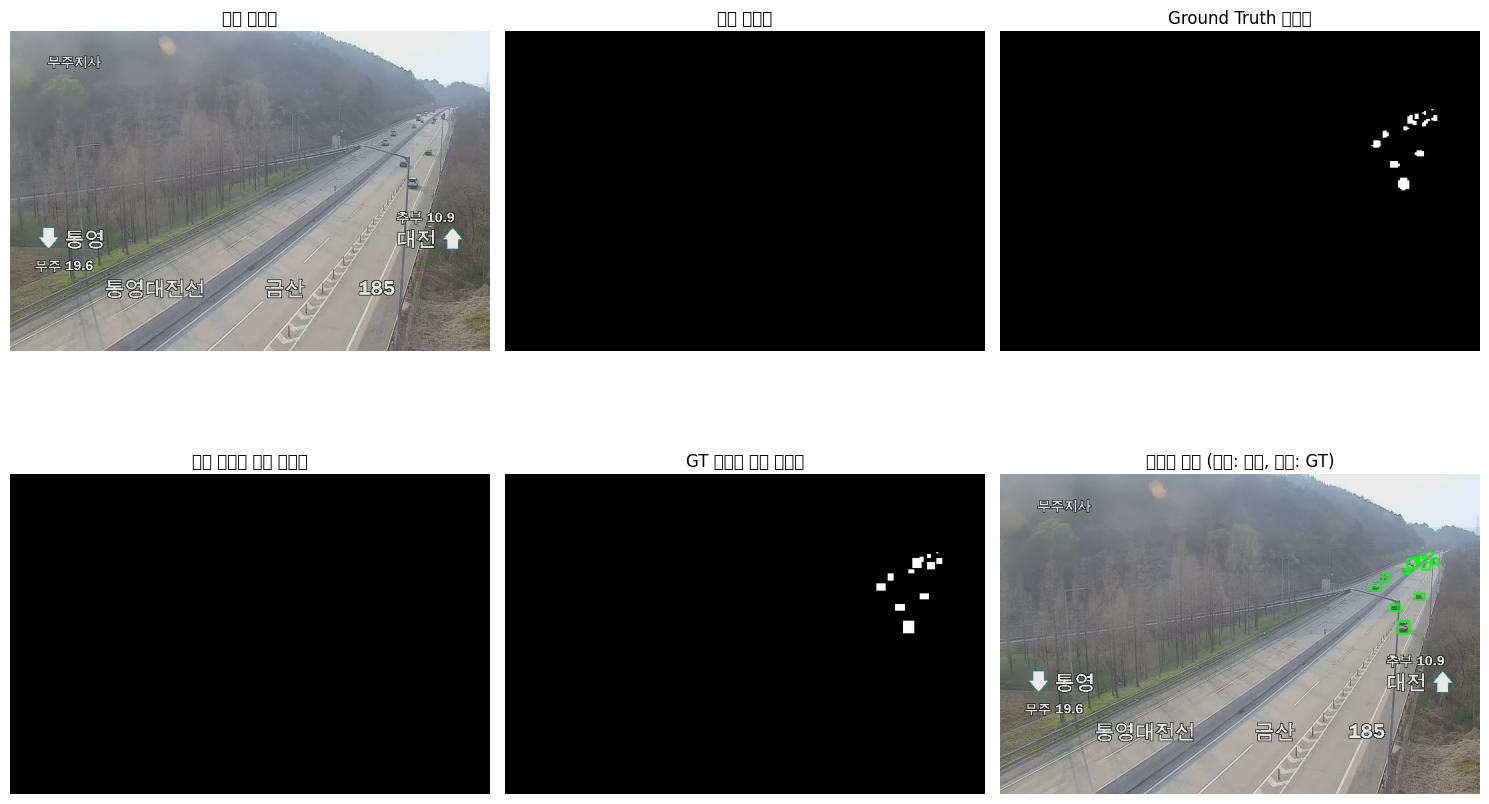

샘플 3 - 마스크 IoU: 0.0000, 박스 IoU: 0.0000, Precision: 0.0000, Recall: 0.0000


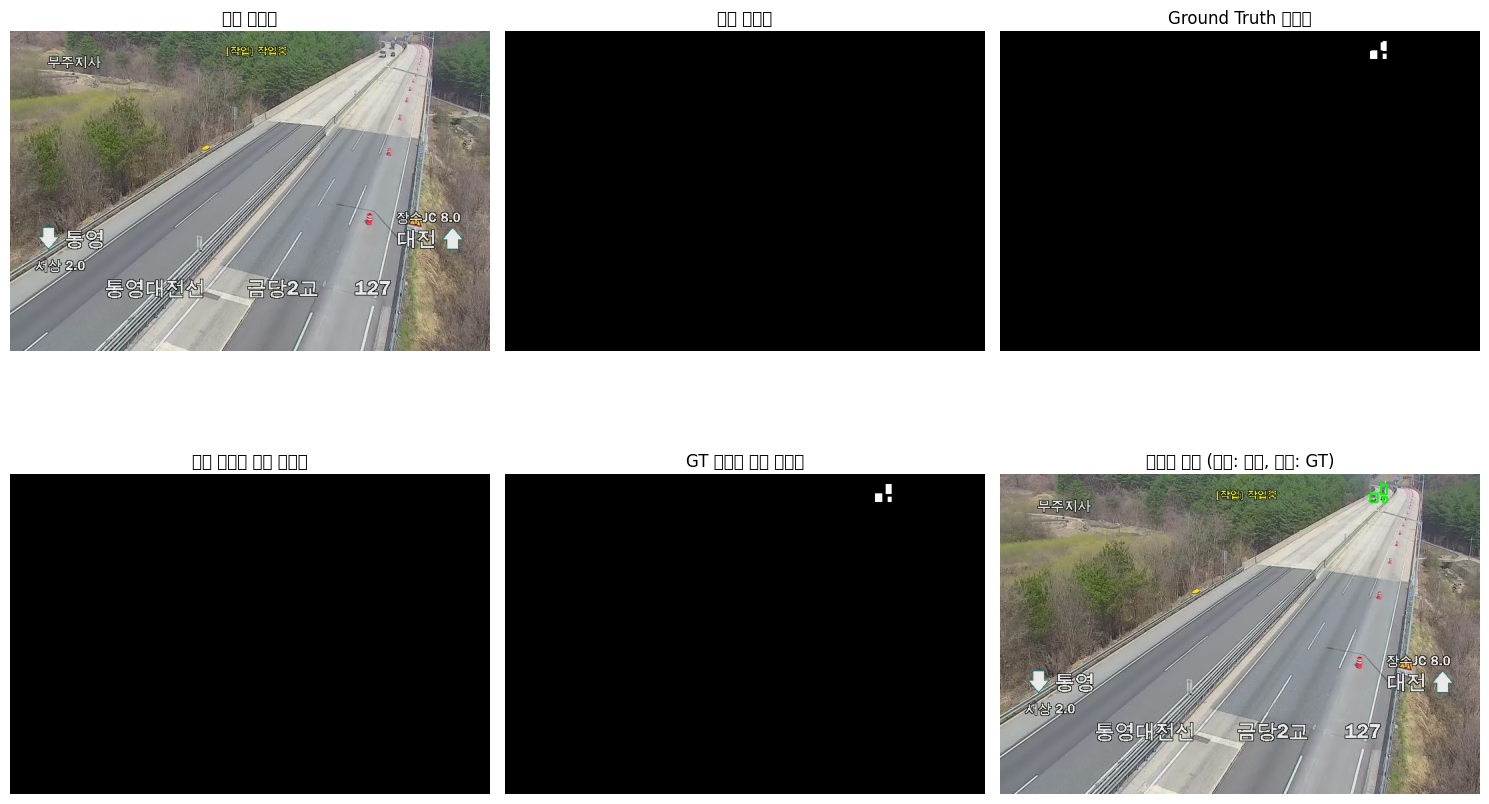

샘플 4 - 마스크 IoU: 0.0000, 박스 IoU: 0.0000, Precision: 0.0000, Recall: 0.0000


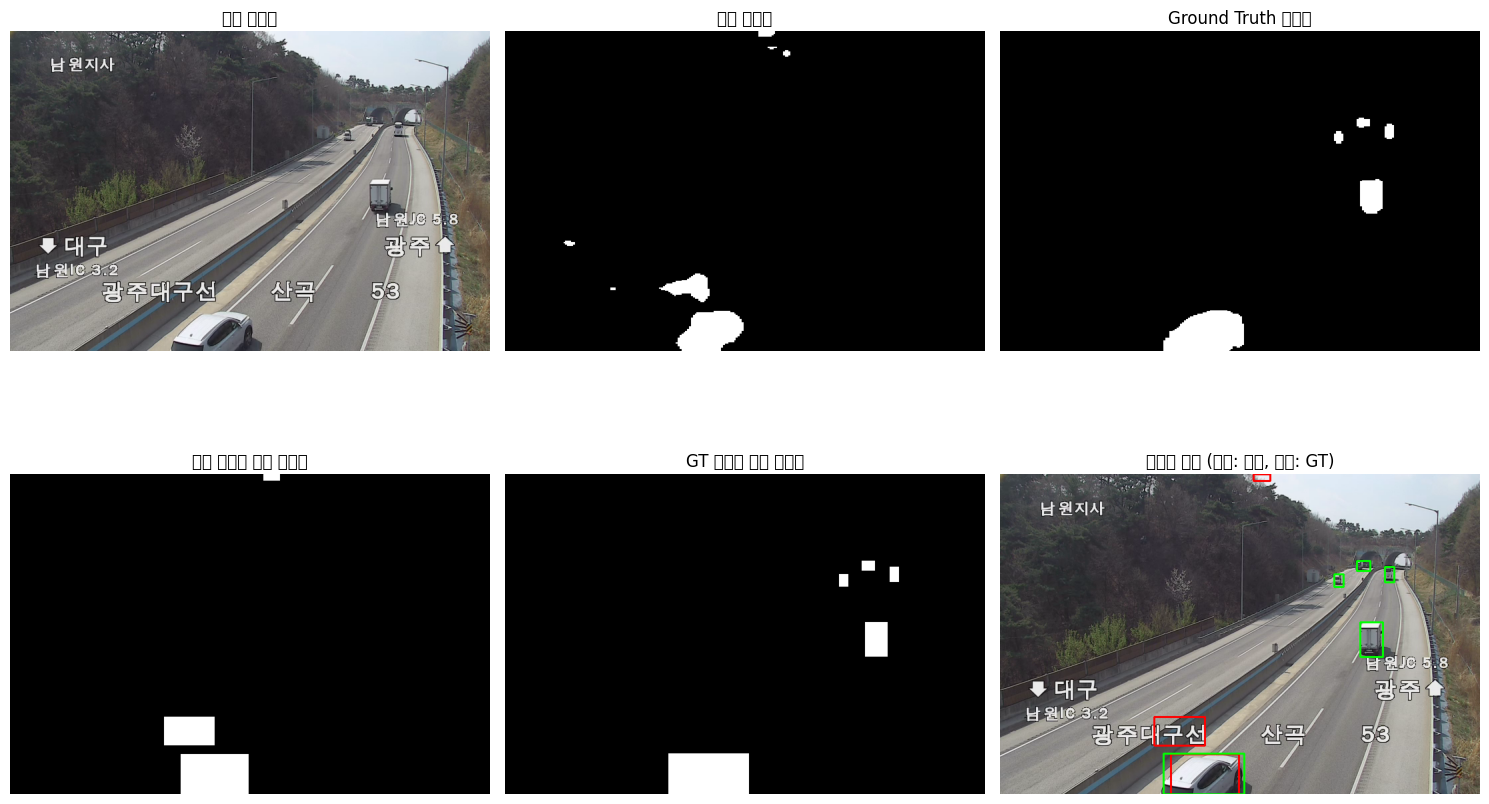

샘플 5 - 마스크 IoU: 0.4176, 박스 IoU: 0.4515, Precision: 0.6350, Recall: 0.6097

SegFormer Cityscapes 모델 성능:
평균 마스크 IoU: 0.2100
평균 박스 IoU: 0.2139
평균 Precision: 0.3853
평균 Recall: 0.3140
F1 Score: 0.3460
메타데이터가 'segformer_cityscapes_metadata.json' 파일로 저장되었습니다.


In [13]:
# 모델 평가 (학습된 모델이 있는 경우 실행)
if 'trained_model' in locals() and 'test_data' in locals() and len(test_data) > 0:
    model_results = evaluate_model(
        model=trained_model,
        test_data=test_data,
        device=device,
        threshold=0.5,
        min_area=100
    )
else:
    print("학습된 모델 또는 테스트 데이터가 준비되지 않았습니다.")

## 6. 메타데이터 전송 구현

In [14]:
def generate_metadata(frame_path, diff_path, model, device, threshold=0.5, min_area=100):
    """
    프레임과 Diff 이미지로부터 메타데이터 생성

    Args:
        frame_path: 프레임 이미지 경로
        diff_path: Diff 이미지 경로
        model: AI 모델
        device: 장치
        threshold: 세그멘테이션 임계값
        min_area: 최소 윤곽선 면적
    """
    # 타임스탬프 추출
    timestamp = re.search(r'(\d{4}-\d{2}-\d{2}_\d{2}-\d{2}-\d{2})', frame_path).group(1)

    # 이미지 로드 및 전처리
    frame = cv2.imread(frame_path)
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)  # BGR -> RGB

    diff = cv2.imread(diff_path, cv2.IMREAD_GRAYSCALE)  # Grayscale
    diff = np.expand_dims(diff, axis=2)  # (H, W) -> (H, W, 1)

    # 크기 조정
    transform = A.Compose([
        A.Resize(256, 256),
    ], additional_targets={'diff': 'image'})

    augmented = transform(image=frame, diff=diff)
    frame = augmented['image']
    diff = augmented['diff']

    # 텐서 변환
    frame = frame.transpose(2, 0, 1).astype('float32') / 255.0  # (H, W, 3) -> (3, H, W)
    diff = diff.transpose(2, 0, 1).astype('float32') / 255.0    # (H, W, 1) -> (1, H, W)

    # 입력: frame(RGB)와 diff 연결 -> 4채널 입력
    x_combined = np.concatenate([frame, diff], axis=0)  # (4, H, W)

    # 모델 예측
    model.eval()
    with torch.no_grad():
        inputs = torch.from_numpy(x_combined).unsqueeze(0).to(device)  # (1, 4, H, W)
        outputs = model(inputs)
        probs = torch.softmax(outputs, dim=1)[:, 1]  # 클래스 1(움직임)의 확률
        pred_mask = (probs > threshold).cpu().numpy()[0].astype(np.uint8)  # (H, W)

    # 원본 크기로 복원
    original_frame = cv2.imread(frame_path)
    original_height, original_width = original_frame.shape[:2]
    pred_mask_resized = cv2.resize(pred_mask, (original_width, original_height), interpolation=cv2.INTER_NEAREST)

    # 바운딩 박스 생성
    contours, _ = cv2.findContours(pred_mask_resized, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    bounding_boxes = []
    for contour in contours:
        if cv2.contourArea(contour) < min_area:
            continue
        x, y, w, h = cv2.boundingRect(contour)
        bounding_boxes.append({'x': x, 'y': y, 'width': w, 'height': h})

    # 메타데이터 생성
    metadata = {
        'timestamp': timestamp,
        'bounding_boxes': bounding_boxes
    }

    return metadata

In [15]:
def simulate_metadata_transmission(metadata):
    """
    메타데이터 전송 시뮬레이션

    Args:
        metadata: 전송할 메타데이터
    """
    # 메타데이터를 JSON 문자열로 변환
    json_data = json.dumps(metadata)

    # 메타데이터 크기 계산 (바이트)
    metadata_size = len(json_data.encode('utf-8'))

    # 원본 프레임 크기 계산 (예상치)
    frame_width = 720  # 예상 프레임 너비
    frame_height = 480  # 예상 프레임 높이
    frame_size = frame_width * frame_height * 3  # RGB 이미지 (3 바이트/픽셀)

    # 압축률 계산
    compression_ratio = frame_size / metadata_size

    print(f"메타데이터 크기: {metadata_size} 바이트")
    print(f"예상 원본 프레임 크기: {frame_size} 바이트")
    print(f"압축률: {compression_ratio:.2f}x")
    print(f"대역폭 절약: {(1 - 1/compression_ratio) * 100:.2f}%")

    # 메타데이터 내용 출력
    print("\n메타데이터 내용:")
    print(json.dumps(metadata, indent=2))

    return {
        'metadata_size': metadata_size,
        'frame_size': frame_size,
        'compression_ratio': compression_ratio
    }

In [ ]:
# 메타데이터 생성 및 전송 시뮬레이션 (테스트 데이터가 있는 경우 실행)
if 'trained_model' in locals() and 'test_data' in locals() and len(test_data) > 0:
    # 첫 번째 테스트 데이터 사용
    sample_data = test_data[0]

    # 메타데이터 생성
    metadata = generate_metadata(
        frame_path=sample_data['frame'],
        diff_path=sample_data['diff'],
        model=trained_model,
        device=device,
        threshold=0.5,
        min_area=100
    )

    # 메타데이터 전송 시뮬레이션
    transmission_results = simulate_metadata_transmission(metadata)
else:
    print("Null")

메타데이터 크기: 251 바이트
예상 원본 프레임 크기: 1036800 바이트
압축률: 4130.68x
대역폭 절약: 99.98%

메타데이터 내용:
{
  "timestamp": "2025-03-30_13-51-00",
  "bounding_boxes": [
    {
      "x": 90,
      "y": 315,
      "width": 29,
      "height": 14
    },
    {
      "x": 180,
      "y": 299,
      "width": 48,
      "height": 35
    },
    {
      "x": 450,
      "y": 235,
      "width": 26,
      "height": 34
    },
    {
      "x": 330,
      "y": 162,
      "width": 19,
      "height": 13
    }
  ]
}
